## Data Collection

This is a dataset which contains a list of beers in the U.S. We're goint to predict the alcohol quantity of each beer by looking at features like the size of beer in ounces, the Beer style (lager, ale, IPA), e.t.c. This will be a supervized regression problem.

From the data dictionary, we can understand that:
1. abv: The alcoholic content by volume with 0 being no alcohol and 1 being pure alcohol
2. ibu: International bittering units, which describe how bitter a drink is.
3. id: Unique ID of each beer
4. name: Name of the beer.
5. style: Beer style (lager, ale, IPA, etc.)
6. brewery_id: Unique identifier for brewery that produces this beer; can use to join with brewery info.
7. ounces: Size of beer in ounces.

In [1]:
# standard libraries for working with data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# loading in the data
beers = pd.read_csv('/Users/Tejas/csv_files/Craft Beers Dataset/beers.csv', index_col='Unnamed: 0')
# looking at the first five rows
beers.head()

,abv,ibu,id,name,style,brewery_id,ounces
0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


## Data Preperation

In [3]:
# Looking at the number of missing values
beers.isnull().sum()

abv             62
ibu           1005
id               0
name             0
style            5
brewery_id       0
ounces           0
dtype: int64

In [4]:
# looking at the shape of the data
beers.shape

(2410, 7)

In [5]:
# Finding the percentage of missing values in the data
beers.isnull().sum() / beers.shape[0] * 100

abv            2.572614
ibu           41.701245
id             0.000000
name           0.000000
style          0.207469
brewery_id     0.000000
ounces         0.000000
dtype: float64

In [6]:
# Looking at the various datatypes 
beers.dtypes

abv           float64
ibu           float64
id              int64
name           object
style          object
brewery_id      int64
ounces        float64
dtype: object

In [7]:
# Getting a brief statistical summary of the data
beers.describe()

,abv,ibu,id,brewery_id,ounces
count,2348.000000,1405.000000,2410.000000,2410.000000,2410.000000
mean,0.059773,42.713167,1431.113278,231.749793,13.592241
std,0.013542,25.954066,752.459975,157.685604,2.352204
min,0.001000,4.000000,1.000000,0.000000,8.400000
25%,0.050000,21.000000,808.250000,93.000000,12.000000
50%,0.056000,35.000000,1453.500000,205.000000,12.000000
75%,0.067000,64.000000,2075.750000,366.000000,16.000000
max,0.128000,138.000000,2692.000000,557.000000,32.000000


A general rule of thumb is to impute missing values which account for less than 60% of the data, and to drop those that do. Since none of them cross the threshold, we'll choose to impute them.

In [8]:
beers = beers.fillna(beers.mean())
beers.isnull().sum()

abv           0
ibu           0
id            0
name          0
style         5
brewery_id    0
ounces        0
dtype: int64

There's still some missing values in the style column. we'll impute this with the most frequent value of that column.

In [9]:
# filling in missing values with the mode
beers['style'] = beers['style'].fillna('American IPA')

## Feature Engineering and Feature Selection

In [10]:
# importing a function that can select the best features
from sklearn.feature_selection import mutual_info_regression

In [11]:
# defining our own function to look at the best features
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='mi_scores', index=X.columns).sort_values(ascending=False)
    return mi_scores

In [12]:
beers.head()

,abv,ibu,id,name,style,brewery_id,ounces
0,0.050,42.713167,1436,Pub Beer,American Pale Lager,408,12.0
1,0.066,42.713167,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,0.071,42.713167,2264,Rise of the Phoenix,American IPA,177,12.0
3,0.090,42.713167,2263,Sinister,American Double / Imperial IPA,177,12.0
4,0.075,42.713167,2262,Sex and Candy,American IPA,177,12.0


The style column may be a categorical column with a large amount of cardinality. we can use the MEstimateEncoder function from sklearn to encode this by blending the in-category average with the overall average. Rare categories get less weight on their category average, while missing categories just get the overall average.

In [13]:
# using a target encoder to encode the style column
from category_encoders.m_estimate import MEstimateEncoder

# Create the encoder instance. Choose m to control noise
def make_target_encoder(X, y, cols, m):
    encoder = MEstimateEncoder(cols=cols, m=m)
    encoder.fit(X, y)
    X_encoded = encoder.transform(X)
    return X_encoded

In [14]:
# creating a copy of the dataset to eperiment on
X = beers.copy()
y = X.abv
X = X.drop('abv', axis=1)

In [15]:
# encoding the style column
X_encoded = make_target_encoder(X, y, cols=['style'], m=5)
X_encoded.head()

,ibu,id,name,style,brewery_id,ounces
0,42.713167,1436,Pub Beer,0.052578,408,12.0
1,42.713167,2265,Devil's Cup,0.054806,177,12.0
2,42.713167,2264,Rise of the Phoenix,0.064326,177,12.0
3,42.713167,2263,Sinister,0.085613,177,12.0
4,42.713167,2262,Sex and Candy,0.064326,177,12.0


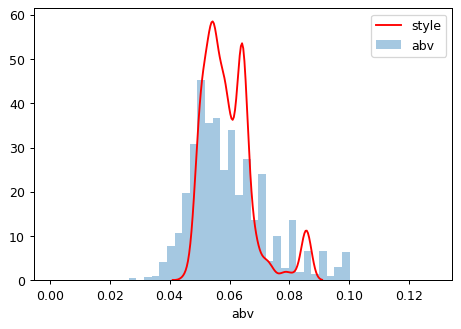

In [16]:
# seeing how much information we captured by encoding that column.
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_encoded['style'], color='r', ax=ax)
ax.set_xlabel("abv")
ax.legend(labels=['style', 'abv']);

The distribution of the encoded style feature roughly follows the distribution of the alcohol content, meaning that our target encoding was able to capture useful information.

Now we'll use KMeans to cluster our data.

In [17]:
X_encoded = X_encoded.drop('name', axis=1)

We might want to go ahead and remove the 'id' and the 'brewery_id' columns as they probably won't be of much help making predictions due to them being unique identifiers.

In [18]:
X_encoded = X_encoded.drop(['id', 'brewery_id'], axis=1)

In [19]:
# Importing and using KMeans to create the cluster column 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15)
X_encoded['cluster'] = kmeans.fit_predict(X_encoded)
X_encoded['cluster'] = X_encoded['cluster'].astype('category')

In [20]:
X_encoded.head()

,ibu,style,ounces,cluster
0,42.713167,0.052578,12.0,0
1,42.713167,0.054806,12.0,0
2,42.713167,0.064326,12.0,0
3,42.713167,0.085613,12.0,0
4,42.713167,0.064326,12.0,0


Now we'll use Principal Component Analysis to create more potentially usefull features.

In [21]:
from sklearn.decomposition import PCA

In [22]:
# Using PCA function to create a new dataframe
pca = PCA()
X_pca = pca.fit_transform(X_encoded)
component_names = [f"PC_{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(X_pca, columns=component_names)
X_pca.head()

,PC_1,PC_2,PC_3,PC_4
0,0.082274,-4.987304,-0.186696,-0.005701
1,0.082274,-4.987303,-0.186696,-0.003473
2,0.082277,-4.987300,-0.186694,0.006048
3,0.082282,-4.987295,-0.186690,0.027334
4,0.082277,-4.987300,-0.186694,0.006048


In [23]:
# merging the two dataframes
X_new = pd.concat([X_encoded, X_pca], axis=1)
X_new.head()

,ibu,style,ounces,cluster,PC_1,PC_2,PC_3,PC_4
0,42.713167,0.052578,12.0,0,0.082274,-4.987304,-0.186696,-0.005701
1,42.713167,0.054806,12.0,0,0.082274,-4.987303,-0.186696,-0.003473
2,42.713167,0.064326,12.0,0,0.082277,-4.987300,-0.186694,0.006048
3,42.713167,0.085613,12.0,0,0.082282,-4.987295,-0.186690,0.027334
4,42.713167,0.064326,12.0,0,0.082277,-4.987300,-0.186694,0.006048


Let's select the best features with the data we have now.

In [24]:
# seeing if there are any discrete_features
discrete_features = X_new.dtypes == int
discrete_features

ibu        False
style      False
ounces     False
cluster    False
PC_1       False
PC_2       False
PC_3       False
PC_4       False
dtype: bool

In [25]:
make_mi_scores(X_new, y, discrete_features)

style      0.563910
PC_1       0.561815
PC_3       0.499356
PC_2       0.478880
PC_4       0.431383
ibu        0.344317
cluster    0.283809
ounces     0.044676
Name: mi_scores, dtype: float64

We'll use these features for our model.

## Comparing different Regression Models with a performance metric

In [26]:
# Looking at all the regression models in scikitlearn
from sklearn.utils.testing import all_estimators
from sklearn import base

estimators = all_estimators()

for name, class_ in estimators:
    if issubclass(class_, base.RegressorMixin):
        print(name)

/Users/Tejas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


ARDRegression
AdaBoostRegressor
BaggingRegressor
BayesianRidge
CCA
DecisionTreeRegressor
DummyRegressor
ElasticNet
ElasticNetCV
ExtraTreeRegressor
ExtraTreesRegressor
GammaRegressor
GaussianProcessRegressor
GeneralizedLinearRegressor
GradientBoostingRegressor
HistGradientBoostingRegressor
HuberRegressor
IsotonicRegression
KNeighborsRegressor
KernelRidge
Lars
LarsCV
Lasso
LassoCV
LassoLars
LassoLarsCV
LassoLarsIC
LinearRegression
LinearSVR
MLPRegressor
MultiOutputRegressor
MultiTaskElasticNet
MultiTaskElasticNetCV
MultiTaskLasso
MultiTaskLassoCV
NuSVR
OrthogonalMatchingPursuit
OrthogonalMatchingPursuitCV
PLSCanonical
PLSRegression
PassiveAggressiveRegressor
PoissonRegressor
RANSACRegressor
RadiusNeighborsRegressor
RandomForestRegressor
RegressorChain
Ridge
RidgeCV
SGDRegressor
SVR
StackingRegressor
TheilSenRegressor
TransformedTargetRegressor
TweedieRegressor
VotingRegressor
_SigmoidCalibration


We'll try a handful of these models (The more popular ones) and establish a baseline to see which one we can go forward with.

In [27]:
# splitting our model into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_new, y, random_state=42, train_size=.7)

In [28]:
X_train.dtypes

ibu         float64
style       float64
ounces      float64
cluster    category
PC_1        float64
PC_2        float64
PC_3        float64
PC_4        float64
dtype: object

In [29]:
# importing XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# training and fitting the model
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

# getting predictions
gb_preds = gb.predict(X_val)

# getting an error metric
from sklearn.metrics import mean_absolute_error

# calculating the mean absolute error (MAE)
gb_mae = mean_absolute_error(y_val, gb_preds)
gb_mae

0.005897643651964802

In [30]:
# importing RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

forest_preds = forest.predict(X_val)

forest_mae = mean_absolute_error(y_val, forest_preds)
forest_mae

0.006128101791478565

In [31]:
# importing SVR
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)

svr_preds = svr.predict(X_val)

svr_mae = mean_absolute_error(y_val, svr_preds)
svr_mae

0.011547448050310905

In [32]:
# importing LinearRegression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_val)

lr_mae = mean_absolute_error(y_val, lr_preds)
lr_mae

0.006143833702740347

In [33]:
# importing KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

knn_preds = knn.predict(X_val)

knn_mae = mean_absolute_error(y_val, knn_preds)
knn_mae

0.006498895619944346

Looks like the model that performed the best was the Gradient Boosting Regressor. We'll go ahead with this model and perform stratified cross validation as well as tune its hyperparameters to try and increase predictive power.

## Hyperparameter Tuning and Cross Validation

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
# using a model with default hyperparameters as well as the model we will use for tweaking
gb_default = GradientBoostingRegressor(random_state=42)

gb_tweaked = GradientBoostingRegressor(loss='lad',
                               learning_rate=.1,
                               n_estimators=800,
                              max_depth=5,
                              random_state=42,
                              max_features='auto',
                              alpha=.9,)

scores = cross_val_score(gb_default, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
scores = -(scores)
scores.mean()

0.005968220689619445

There was little difference in the scores of both models.

Looks like our Gradient Boosting model performed well on our stratified validation set. To get a better representation of this, let's plot the learning curve.

## Looking At The Results

In [36]:
from sklearn.model_selection import learning_curve

In [37]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = gb_default,
    X = X_train,
    y = y_train, 
    cv = 5,
    scoring = 'neg_mean_absolute_error'
)

In [38]:
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 134     0.002756
438     0.004273
741     0.004743
1045    0.004972
1349    0.005166
dtype: float64

 --------------------

Mean validation scores

 134     0.006866
438     0.006390
741     0.006133
1045    0.006002
1349    0.005955
dtype: float64


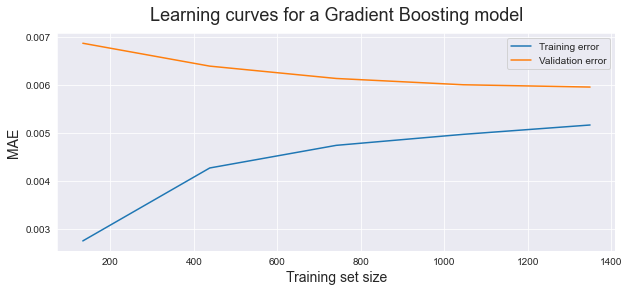

In [39]:
plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MAE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a Gradient Boosting model', fontsize = 18, y = 1.03)
plt.legend()

plt.show()